# Example of using The Module Formerly Known as KDE and Asy_peakbag for KIC7976303

This is a notebook showing a rough draft of the replacement module for KDE and Asy_peakbag, which is currently WIP on the PBjam-dev branch.

We'll start by importing the modeID sampler (Should the name be changed?)

In [1]:
%load_ext autoreload
%autoreload 2
from pbjam.modeID import modeIDsampler
from pbjam import IO
import corner
import jax.numpy as jnp

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


We'll also use the IO module to load the PSD. This is a new module that contains all I/O related matters, saving/loading/downloading etc. The largest part of this is wrapping the various lightkurve steps to getting a PSD. However it now also stores lightkurve search results so that cached data are loaded more quickly. 

The IO.psd class also normalizes the PSD consistently (Parseval). This is important now that we're working on the PSD and not the SNR spectrum.

In [2]:
psd = IO.psd('KIC7976303', lk_kwargs={'exptime': 60, 'mission':'Kepler', 'author':'Kepler'})
#psd = IO.psd('TIC95473936', lk_kwargs={'exptime': 120, 'mission':'TESS', 'author':'SPOC'})

psd()

f = psd.freq[::10]

s = psd.powerdensity[::10]

Using cached search result.
Loading fits files from cache.


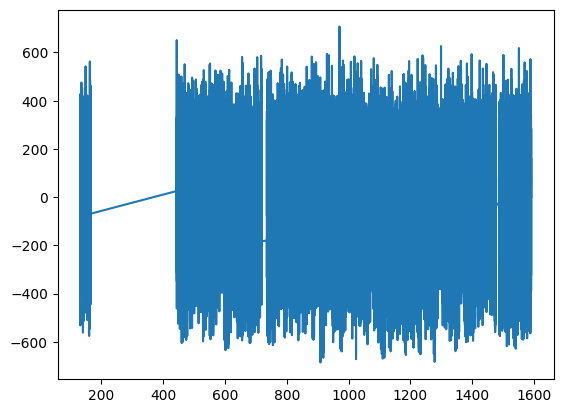

In [3]:
import matplotlib.pyplot as plt
plt.plot(psd._time, psd._flux)

## Priors
With the update to PBjam most of the parameters are included in the dimensionality reduction (DR). The latent parameter priors are constructed by the DR module, using the the prior sample of the model parameters. For the g-mode parameters the prior sample is not even remotely complete however. To get around this we can supply the modeID class with a list of priors for these parameters. They will then automatically be removed from the list of parameters included in the DR.

These priors are all in the form of class instances of distributions, similar to the scipy.stats classes. However, here we're using a set of custom classes that have been jaxed.

In [55]:
import pbjam.distributions as dist
import numpy as np

addObs = {'numax' : (900.17, 80),
          'dnu'  : (51.24, 0.21),
          'teff': (6053, 10.0),
          'bp_rp': (0.719, 0.05), 
          } 

addPriors = {'p_L0': dist.beta(a=1.2, b=1.2, loc=0.04, scale=0.06),
             'p_D0': dist.beta(a=1.2, b=1.2, loc=-0.04, scale=0.04),
             'DPi0': dist.normal(loc=0.000519, scale=0.000519*0.01),
             'eps_g': dist.normal(loc=0.81, scale=0.01),
             'd01': dist.normal(loc=np.log10(24), scale=0.01),
             'alpha_g': dist.normal(loc=np.log10(0.02), scale=0.5),
            }

In [56]:
N_p = 15

N_pca = 10

PCAdims = 8
 
M = modeIDsampler(f, s, addObs, addPriors, N_p=N_p, Npca=N_pca, PCAdims=PCAdims, priorpath=IO.get_priorpath(), freq_limits = [100, 2000])

In [82]:
H = modeIDsampler(f, s, addObs, addPriors, N_p=N_p, Npca=N_pca, PCAdims=PCAdims, priorpath=IO.get_priorpath(), freq_limits = [100, 2000])

## Plot the prior
It's always good to check that your prior is reasonable, so lets plot some samples from the prior.

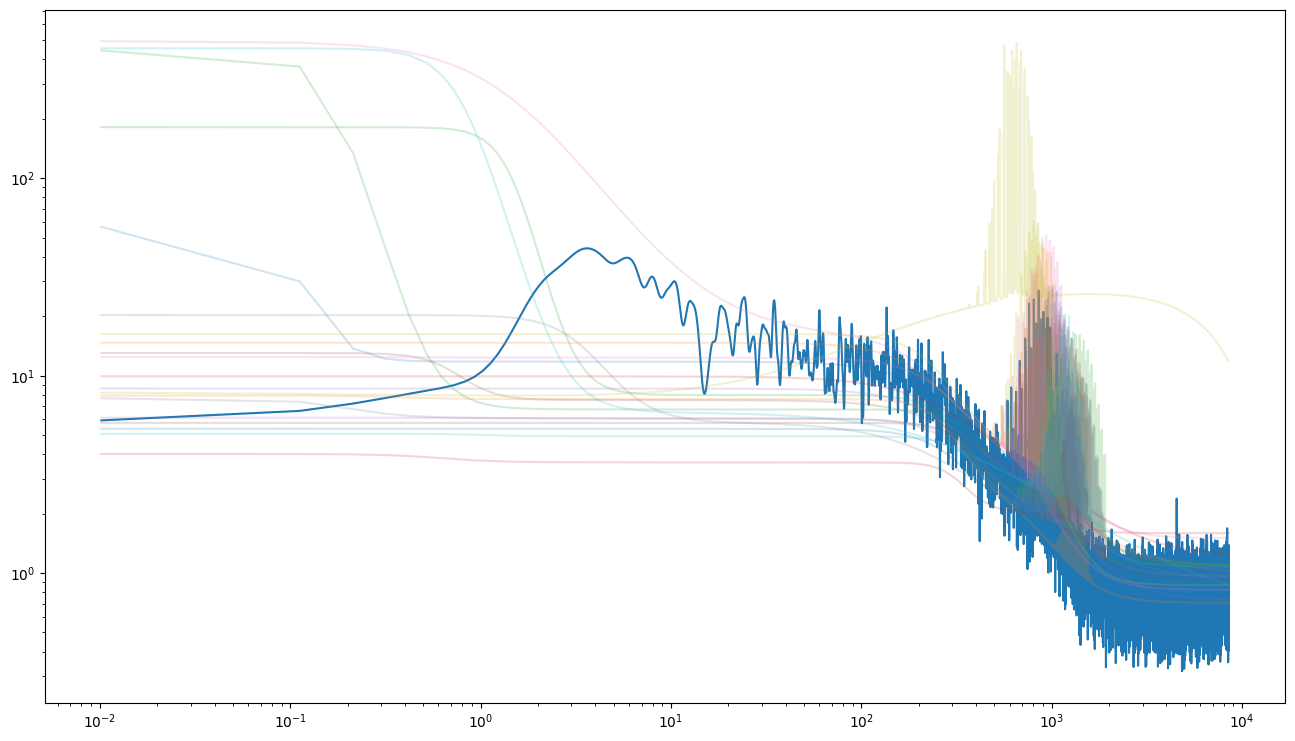

In [57]:
import matplotlib.pyplot as plt
import astropy.convolution as conv
import numpy as np

fac = max([1, 0.5 / (M.f[1] - M.f[0])])
kernel = conv.Gaussian1DKernel(stddev=np.array(fac))
smoo = conv.convolve(M.s, kernel)

N = 20

fig, ax = plt.subplots(figsize=(16,9))

ax.loglog(M.f, smoo)

for i in range(N):
    u = np.random.uniform(0, 1, size=M.ndims)

    theta = M.ptform(u)
    
    theta_u = M.unpackParams(theta)
     
    m = M.model(theta_u, M.f)
    
    ax.loglog(M.f, m, alpha = 0.2)

## Run Dynesty
Time to run! You can optionally run with the dynamic sampler enabled, but it probably won't do you much good and take an order of magnitude longer.

In [84]:
sampler, samples = H(dynesty_kwargs = {'nlive':5000})

ValueError: The log-likelihood (nan) of live point 1168 located at u=[0.99993428 0.16496788 0.13979448 0.31336563 0.17674526 0.38463626
 0.781665   0.96204638 0.50397586 0.68596547 0.22486553 0.71496516
 0.9875786  0.00481053 0.11454782 0.27082576 0.9164749  0.34546492
 0.13344432 0.81385173] v=[ 1.26105197e+01 -2.09269972e+00 -1.58912585e+00 -7.15306882e-01
 -1.01949253e+00 -2.16685269e-01  6.60950953e-01  1.09379960e+00
  7.02136291e-02 -1.32866941e-02  5.15077069e-04  8.15679489e-01
 -5.77050777e-01  1.35431965e+00 -1.88545218e+00  7.53681830e-01
  2.23390255e+00 -2.78242778e-01  2.05914413e+00  4.56415754e-02] is invalid.

In [58]:
sampler, samples = M(dynesty_kwargs = {'nlive':500})

24680it [10:11, 40.37it/s, +500 | bound: 311 | nc: 1 | ncall: 935790 | eff(%):  2.692 | loglstar:   -inf < -33125.476 <    inf | logz: -33174.274 +/-  0.309 | dlogz:  0.001 >  0.509]


## Plot model samples
Time to plot some of the posterior samples

(0.0, 20.0)

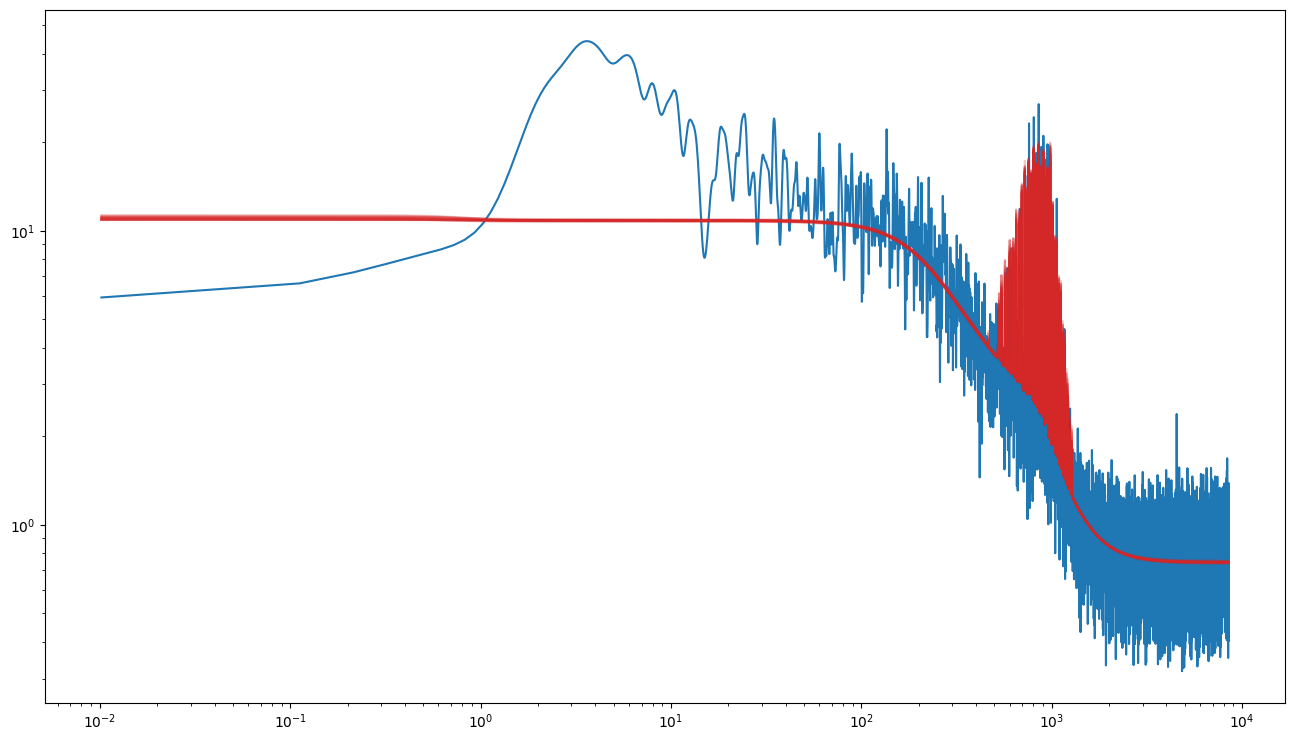

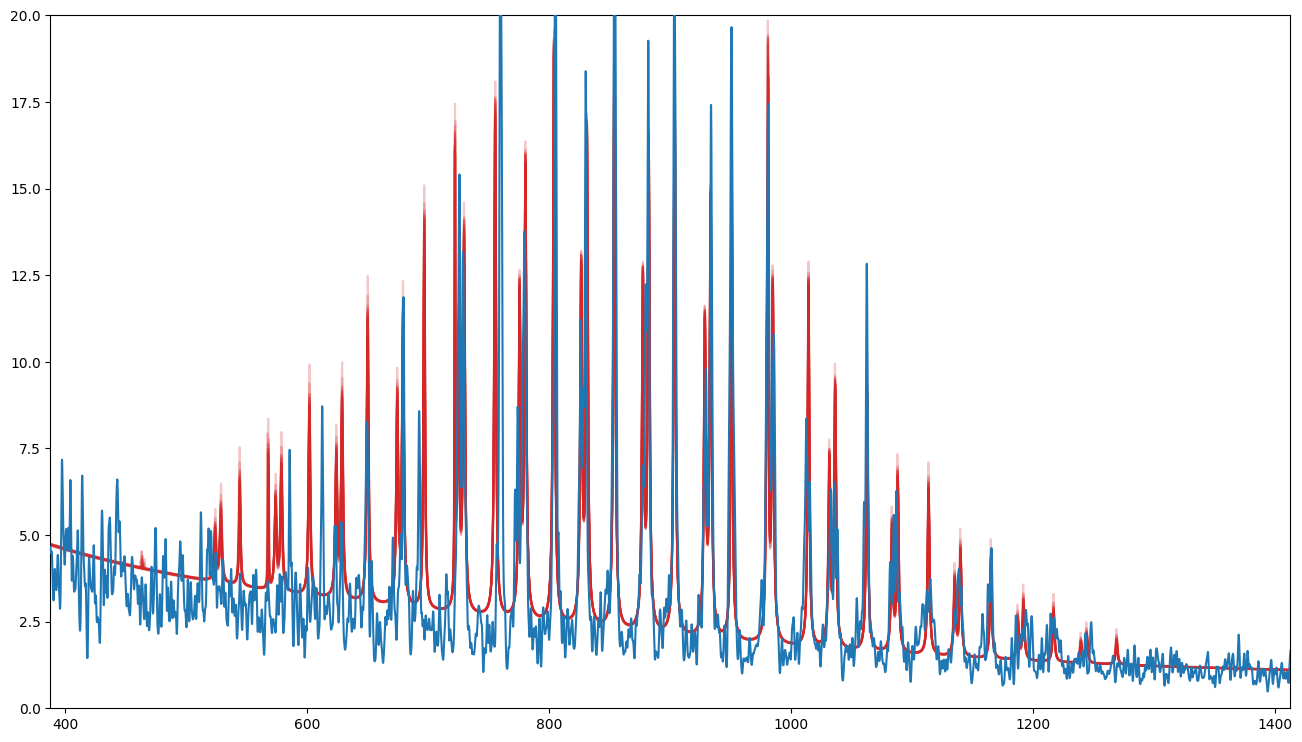

In [60]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(np.array(M.f), smoo)
 
N = 20
for i in np.random.randint(0, M.samples.shape[0], size=N):
     
    theta = M.samples[i, :]

    theta_u = M.unpackParams(theta)
     
    m = M.model(theta_u, M.f)
    
    ax.plot(np.array(M.f), np.array(m), color='C3', alpha=0.25)
    
ax.set_yscale('log')
ax.set_xscale('log')


fig, ax = plt.subplots(figsize=(16,9))
ax.plot(np.array(M.f), np.array(smoo), zorder=99)
 
for i in np.random.randint(0, M.samples.shape[0], size=N):
    
    theta = M.samples[i, :]

    theta_u = M.unpackParams(theta)
     
    m = M.model(theta_u, M.f)
    
    ax.plot(np.array(M.f), np.array(m), color='C3', alpha=0.25)
ax.set_xlim(addObs['numax'][0]-10*addObs['dnu'][0], addObs['numax'][0]+10*addObs['dnu'][0])
#ax.set_xlim(900, 1200)

ax.set_ylim(0, 20)

## Corner plot
We can make a nice corner plot too. However, the samples from the priors contain a mix of latent parameters and model parameters, some in log10, others not. To get everything in terms of linear model parameters we'll need to transform the raw samples

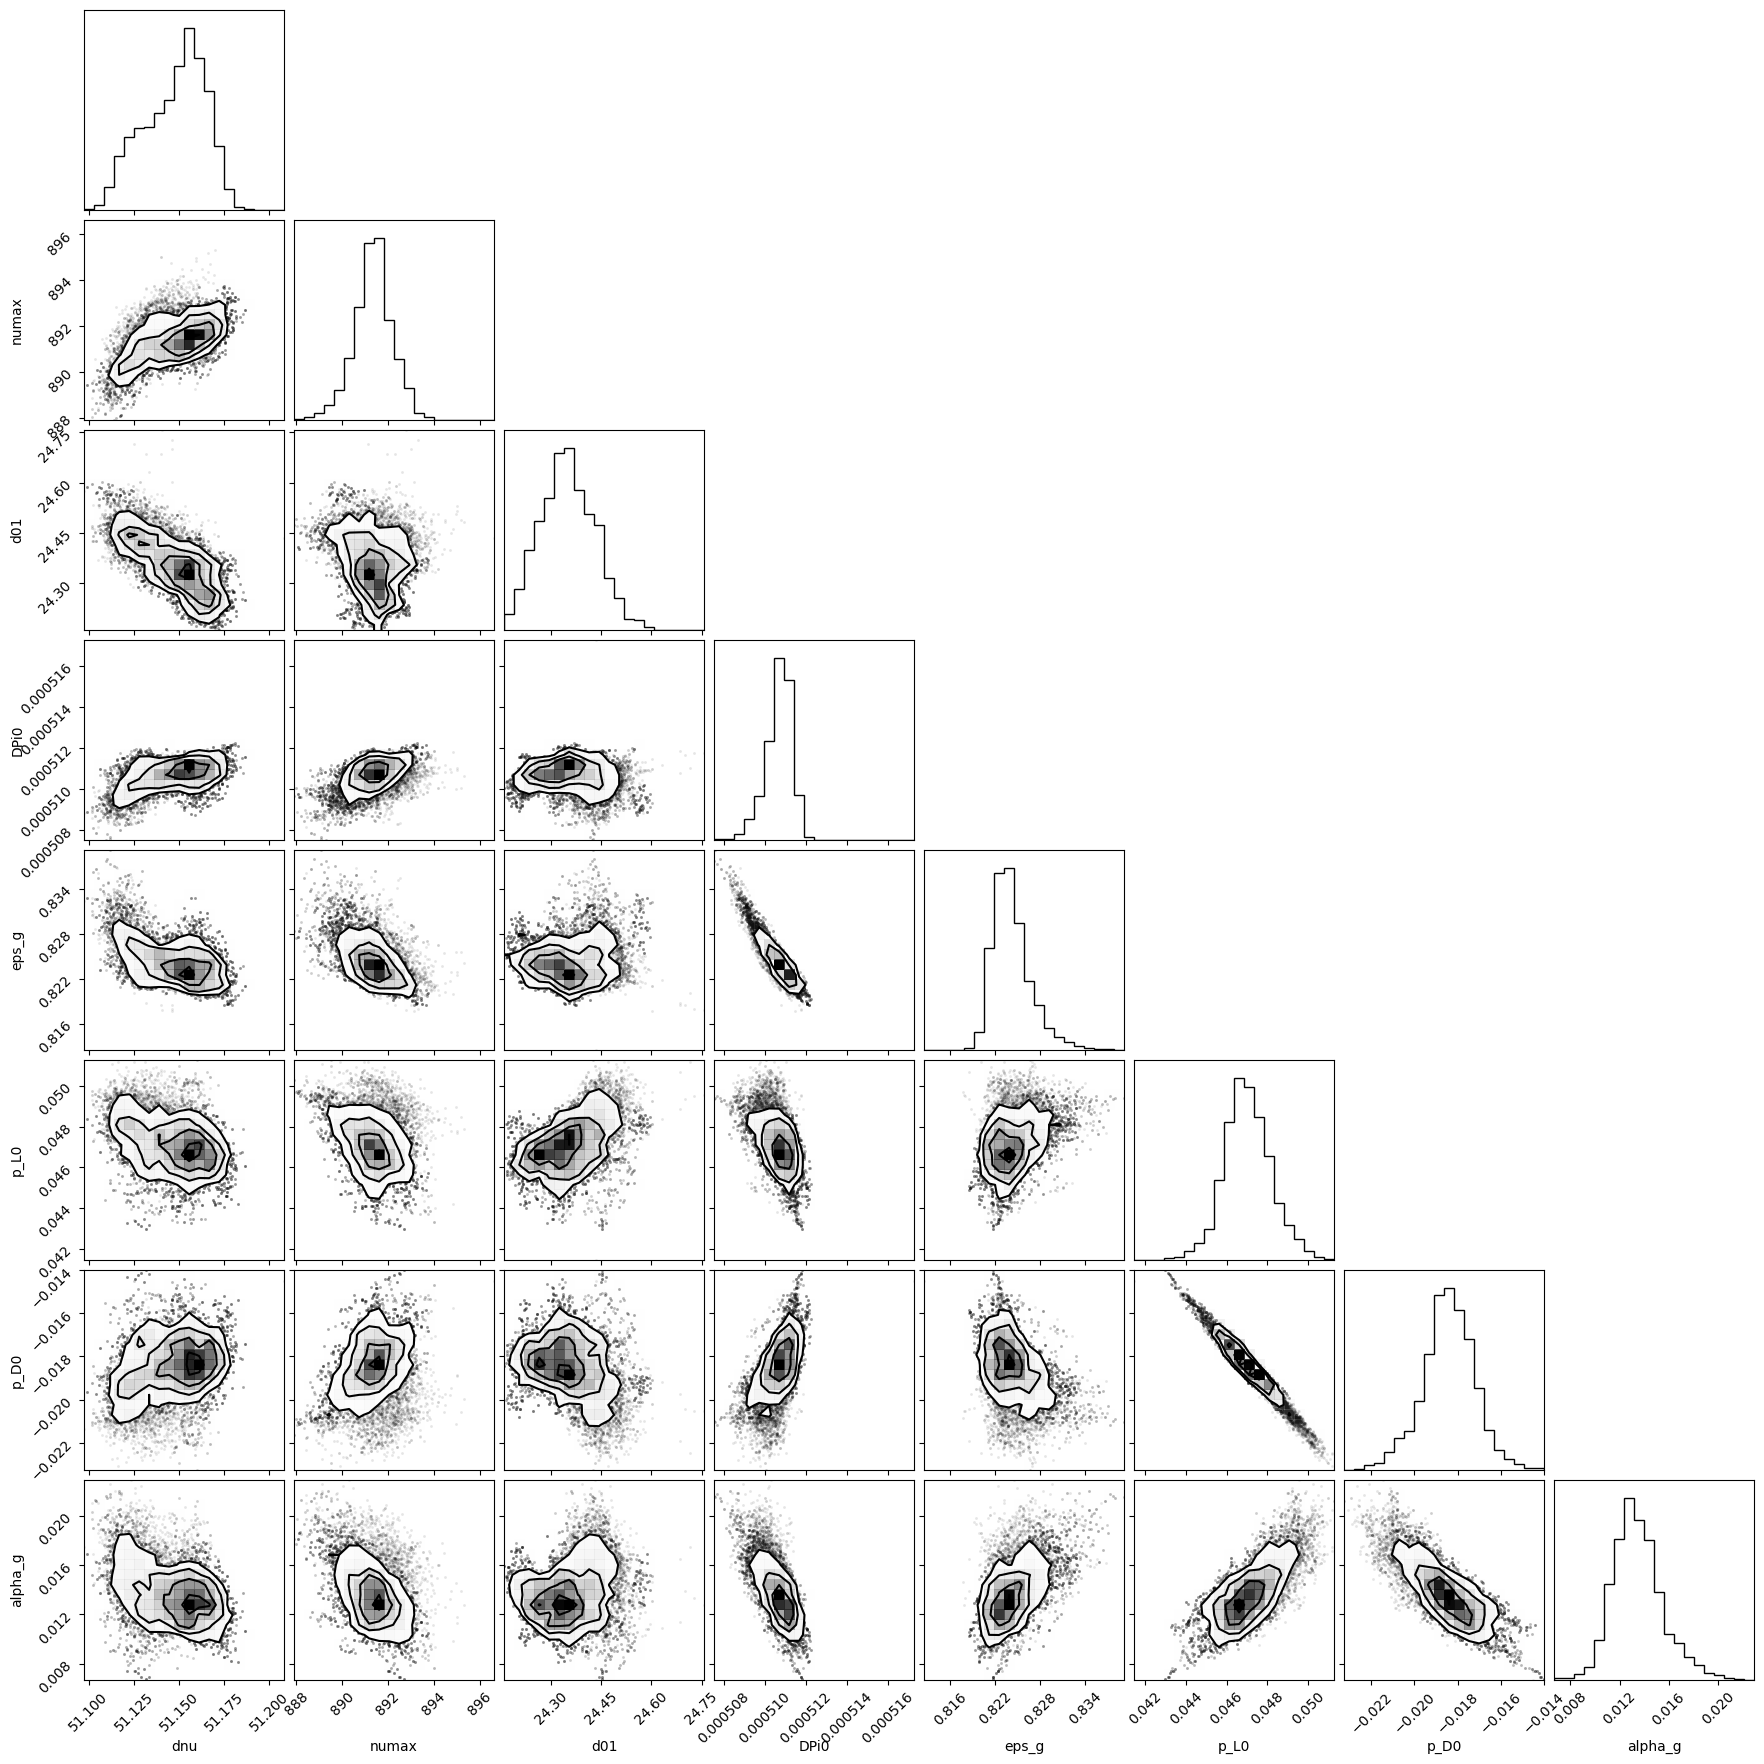

In [61]:
samples_u = M.unpackSamples(M.samples)
corner.corner({k : samples_u[k] for k in ['dnu', 'numax', 'd01', 'DPi0', 'eps_g', 'p_L0', 'p_D0', 'alpha_g']});

In [62]:
#H = np.copy([M])[0]

In [63]:
#M.AsyFreqModel.N_p = 30

In [64]:
#nu0_p, n_p = M.AsyFreqModel.asymptotic_nu_p(numax, dnu, eps_p, alpha_p)

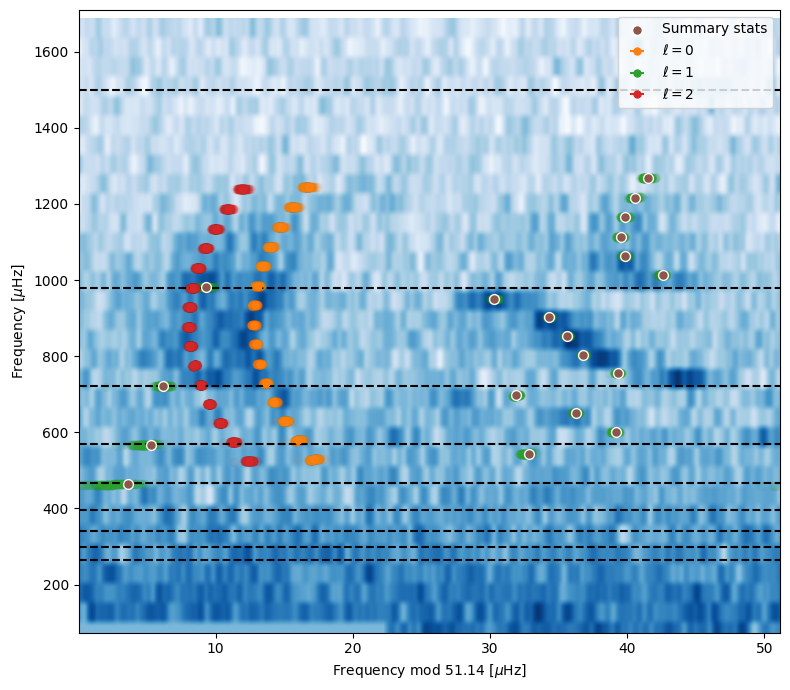

In [65]:
 
fig, ax = M.echelle();
 
d01 =  M.result['summary']['d01'][0] # - 1
DPi0 =  M.result['summary']['DPi0'][0] 
eps_g = M.result['summary']['eps_g'][0] 
alpha_g = M.result['summary']['alpha_g'][0]  
p_L = jnp.array([M.result['summary']['p_L0'][0]   ])
p_D = jnp.array([M.result['summary']['p_D0'][0]  ] )
numax = M.result['summary']['numax'][0]
dnu = M.result['summary']['dnu'][0]  

eps_p = M.result['summary']['eps_p'][0]
alpha_p = M.result['summary']['alpha_p'][0]

nu0_p, n_p = M.AsyFreqModel.asymptotic_nu_p(numax, dnu, eps_p, alpha_p)
nu_g = M.MixFreqModel.asymptotic_nu_g(jnp.arange(10)[::-1], DPi0, eps_g, alpha_g )
nu_m, zeta = M.MixFreqModel.mixed_nu1(nu0_p, n_p, d01, DPi0, p_L, p_D, eps_g, alpha_g)
ax.scatter(nu_m%dnu, nu_m, c='C5', zorder=99, label='Summary stats', s = 50, ec='w')
#ax.scatter(nu0_p%dnu, nu0_p, c='C6', zorder=99, label='Summary stats')
ax.legend()
for nu in nu_g:
    ax.axhline(nu, color='k', ls='dashed')

In [ ]:
eps_g

In [ ]:
#M.result['summary']
import numpy as np
R = {'freq': np.array([[6.33058657e+02, 6.82123631e+02, 7.31570599e+02, 7.81399663e+02,
         8.31612277e+02, 8.82204736e+02, 9.33178355e+02, 9.84530874e+02,
         1.03626226e+03, 1.08837555e+03, 1.14087753e+03, 6.53108784e+02,
         6.97722590e+02, 7.20600452e+02, 7.56617244e+02, 8.04616514e+02,
         8.53910976e+02, 9.03253813e+02, 9.50290011e+02, 9.81918193e+02,
         1.01442276e+03, 1.06252155e+03, 1.11359861e+03, 1.16563152e+03,
         6.28048114e+02, 6.77111993e+02, 7.26562510e+02, 7.76396794e+02,
         8.26607920e+02, 8.77198186e+02, 9.28170478e+02, 9.79525441e+02,
         1.03125825e+03, 1.08336879e+03, 1.13586187e+03],
        [1.90671934e-01, 1.38231555e-01, 1.01417897e-01, 7.83709324e-02,
         7.70919855e-02, 8.50123983e-02, 8.94724109e-02, 8.97913269e-02,
         9.51926435e-02, 1.14912776e-01, 1.50746154e-01, 1.80907655e-01,
         1.88104013e-01, 2.00130526e-01, 8.74526598e-02, 7.02960583e-02,
         7.27470620e-02, 8.26508878e-02, 1.21176801e-01, 2.26737013e-01,
         1.04666074e-01, 9.64919291e-02, 1.08173424e-01, 1.39126803e-01,
         1.71873222e-01, 1.20572010e-01, 8.64692972e-02, 7.54518044e-02,
         8.79507106e-02, 1.00825257e-01, 1.06003441e-01, 1.05589208e-01,
         9.89136510e-02, 1.08088295e-01, 1.37405735e-01]]),
 'height': np.array([[1.24891478, 2.24192427, 3.59559489, 5.13846505, 6.5343525 ,
         7.36092576, 7.33124456, 6.43887874, 4.97214694, 3.36570328,
         1.99124532, 1.96237051, 3.21641642, 3.99104594, 5.32819783,
         7.11228583, 8.53051194, 9.10100412, 8.68693625, 7.93221408,
         6.87137567, 5.06531803, 3.24335196, 1.81082361, 0.83010771,
         1.50765712, 2.4467637 , 3.53908478, 4.55428778, 5.19331181,
         5.23576326, 4.655792  , 3.63974348, 2.49509143, 1.49453711],
        [0.05381527, 0.06859924, 0.07555366, 0.07409158, 0.07788437,
         0.07565413, 0.07249709, 0.07294219, 0.06914895, 0.06607628,
         0.05725949, 0.07284448, 0.08538578, 0.08835045, 0.09204369,
         0.09083895, 0.09402126, 0.08989597, 0.08871657, 0.09178817,
         0.08507999, 0.08381256, 0.07692093, 0.06223131, 0.03679702,
         0.04754485, 0.05309897, 0.05313551, 0.0546695 , 0.05410282,
         0.05161401, 0.05188571, 0.04903143, 0.04724168, 0.04155403]]),
 'width': np.array([[1.67176396, 1.67176396, 1.67176396, 1.67176396, 1.67176396,
         1.67176396, 1.67176396, 1.67176396, 1.67176396, 1.67176396,
         1.67176396, 1.60151039, 1.23205673, 0.64722752, 1.55595432,
         1.63575069, 1.63830672, 1.60652789, 1.39118743, 0.7220399 ,
         1.42442393, 1.62063798, 1.65212141, 1.66157036, 1.67176396,
         1.67176396, 1.67176396, 1.67176396, 1.67176396, 1.67176396,
         1.67176396, 1.67176396, 1.67176396, 1.67176396, 1.67176396],
        [0.02439656, 0.02439656, 0.02439656, 0.02439656, 0.02439656,
         0.02439656, 0.02439656, 0.02439656, 0.02439656, 0.02439656,
         0.02439656, 0.02381594, 0.01884086, 0.01405279, 0.02338595,
         0.02411789, 0.02424143, 0.024086  , 0.02192312, 0.01094829,
         0.02115664, 0.02395552, 0.02420481, 0.0242522 , 0.02439656,
         0.02439656, 0.02439656, 0.02439656, 0.02439656, 0.02439656,
         0.02439656, 0.02439656, 0.02439656, 0.02439656, 0.02439656]]),
 'dnu': (50.959840313481344, 0.008331186184001638),
 'numax': (906.0240645186933, 0.5145728638584615),
 'eps_p': (1.3107840012464749, 0.0022125768208276497),
 'd02': (5.0059917923685076, 0.02970802165789488),
 'alpha_p': (0.007496910404522531, 0.00022482451148441752),
 'env_width': (144.37366771093625, 1.449801468941871),
 'env_height': (3.730498244147345, 0.03666320096130882),
 'mode_width': (1.6717639638391522, 0.02439655882932501),
 'teff': (6123.422150917753, 1.853720899207019),
 'bp_rp': (0.7292759620591858, 0.0011360890054004646),
 'H1_nu': (970.83860263469, 5.684124531964017),
 'H1_exp': (4.351353636334766, 0.012188915195496808),
 'H_power': (2065.32758280455, 16.3132033726248),
 'H2_nu': (253.3408785364141, 1.3330357603207545),
 'H2_exp': (2.730981869809721, 0.032357566270554416),
 'p_L0': (0.02770626636604024, 0.00019462194517212358),
 'p_D0': (0.0019779636223795946, 2.274632377946475e-06),
 'DPi0': (0.0005176078380151516, 2.353720490597599e-07),
 'eps_g': (0.7941124605720262, 0.0005292046364879233),
 'alpha_g': (0.018164389220591246, 0.0003641228977827645),
 'd01': (23.68592873460547, 0.04767066058558633),
 'nurot_c': (0.016908772719934104, 0.0009059632788174787),
 'inc': (0.3566882326593566, 0.0739001809936384),
 'H3_power': (0.0057307168106949065, 0.005207049100002582),
 'H3_nu': (0.5727039477649756, 0.049059538578471285),
 'H3_exp': (2.0614916980574405, 0.08088443769398634),
 'shot': (0.6920910159914255, 0.008065586136963121)}

In [ ]:
# from pbjam.jar import updatePrior
# prior = updatePrior('KIC7976303', R, addObs)
# prior.to_csv('pbjam/data/prior_data.csv', index=False)

In [75]:
from scipy.linalg import eigh as seigh

In [66]:
nu1_p = nu0_p + d01  
    
nu_g = M.MixFreqModel.asymptotic_nu_g(M.MixFreqModel.n_g, DPi0, eps_g, alpha_g)

L, D = M.MixFreqModel.generate_matrices(n_p, M.MixFreqModel.n_g, nu1_p, nu_g, p_L, p_D)

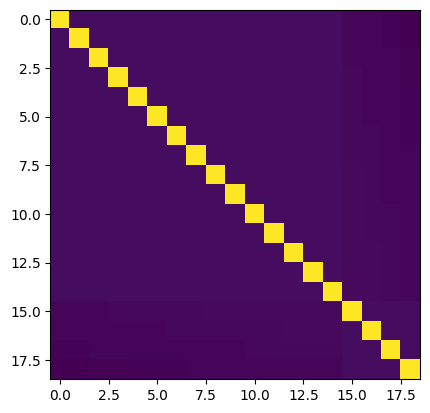

In [70]:
plt.imshow(D)

In [71]:
D

Array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01597929, -0.01946752, -0.02472401, -0.03353713],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01465422, -0.01785319, -0.02267379, -0.03075608],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01352855, -0.01648179, -0.0209321 , -0.02839355],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.   

In [72]:
Lambda, U = M.MixFreqModel.eigh(L, D)

In [78]:
Lambda, U

(Array([-6.35508027e-05, -5.84409597e-05, -5.35687277e-05, -4.89393112e-05,
        -4.45746218e-05, -4.06068787e-05, -3.79842937e-05, -3.56845652e-05,
        -3.22346564e-05, -2.87784773e-05, -2.55103466e-05, -2.25197279e-05,
        -2.05857233e-05, -1.91620931e-05, -1.66745411e-05, -1.42935338e-05,
        -1.27259534e-05, -1.16925582e-05, -8.49284194e-06], dtype=float64),
 Array([[ 3.08550834e-04,  2.55063069e-04,  1.04599703e-04,
          2.77652806e-04,  1.33690762e-03,  5.31208799e-03,
          1.55466538e-02,  1.10466950e-02,  6.80397494e-03,
          5.43565959e-03,  3.78620921e-03,  4.15649980e-03,
          4.55097210e-02,  4.00336553e-02,  3.28553044e-02,
          2.60266793e-02,  4.81597753e-01,  8.69033086e-01,
          9.65497885e-02],
        [ 1.78371517e-04,  7.57517952e-05, -1.57237705e-04,
          6.95974521e-04,  2.11965441e-03,  7.33046282e-03,
          2.04229820e-02,  1.41044877e-02,  8.46698479e-03,
          6.68201647e-03,  4.55363974e-03,  6.4504125

In [76]:
sLambda, sU = seigh(L, D)

In [79]:
sLambda, sU

(array([-6.35508027e-05, -5.84409597e-05, -5.35687277e-05, -4.89393112e-05,
        -4.45746218e-05, -4.06068787e-05, -3.79842937e-05, -3.56845652e-05,
        -3.22346564e-05, -2.87784773e-05, -2.55103466e-05, -2.25197279e-05,
        -2.05857233e-05, -1.91620931e-05, -1.66745411e-05, -1.42935338e-05,
        -1.27259534e-05, -1.16925582e-05, -8.49284194e-06]),
 array([[ 3.08550834e-04,  2.55063069e-04,  1.04599703e-04,
          2.77652806e-04, -1.33690762e-03, -5.31208799e-03,
         -1.55466538e-02,  1.10466950e-02, -6.80397494e-03,
         -5.43565959e-03,  3.78620921e-03, -4.15649980e-03,
         -4.55097210e-02,  4.00336553e-02, -3.28553044e-02,
         -2.60266793e-02,  4.81597753e-01,  8.69033086e-01,
         -9.65497885e-02],
        [ 1.78371517e-04,  7.57517952e-05, -1.57237705e-04,
          6.95974521e-04, -2.11965441e-03, -7.33046282e-03,
         -2.04229820e-02,  1.41044877e-02, -8.46698479e-03,
         -6.68201647e-03,  4.55363974e-03, -6.45041255e-03,
        

In [81]:
np.allclose(U, sU)

False

In [87]:
v=jnp.array([ 1.26105197e+01, -2.09269972e+00, -1.58912585e+00, -7.15306882e-01,
 -1.01949253e+00, -2.16685269e-01,  6.60950953e-01,  1.09379960e+00,
  7.02136291e-02, -1.32866941e-02,  5.15077069e-04,  8.15679489e-01,
 -5.77050777e-01,  1.35431965e+00, -1.88545218e+00,  7.53681830e-01,
  2.23390255e+00, -2.78242778e-01,  2.05914413e+00,  4.56415754e-02])

In [89]:
r = M.unpackParams(v)

In [90]:
nu0_p, n_p = M.AsyFreqModel.asymptotic_nu_p(r['numax'], r['dnu'], r['eps_p'], r['alpha_p'])

nu1_p = nu0_p + r['d01']  
    
nu_g = M.MixFreqModel.asymptotic_nu_g(M.MixFreqModel.n_g, r['DPi0'], r['eps_g'], r['alpha_g'])

L, D = M.MixFreqModel.generate_matrices(n_p, M.MixFreqModel.n_g, nu1_p, nu_g, r['p_L'], r['p_D'])

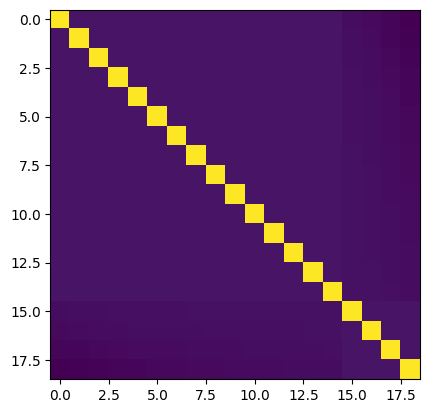

In [94]:
plt.imshow(D)

In [96]:
Lambda, U = M.MixFreqModel.eigh(L, D)

In [107]:
-Lambda

Array([ 3.81427624e-05,  1.97301362e-05,  1.41125674e-05,  1.28333284e-05,
        1.16401198e-05,  1.05633868e-05,  9.82085985e-06,  9.18018879e-06,
        8.25913099e-06,  7.32830979e-06,  6.44674494e-06,  5.63561796e-06,
        5.05602004e-06,  4.71691330e-06,  4.06388237e-06,  3.40967087e-06,
        2.80064404e-06,  2.23526557e-06, -2.68842076e-08], dtype=float64)

In [98]:
sLambda, sU = seigh(L, D)